## Implement Kmeans algorithm
* This is based on [this](https://domino.ai/blog/getting-started-with-k-means-clustering-in-python)

In [1]:
# load libaries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

In [2]:
# download data
#!wget -O ./data/kmeans_blob.csv https://figshare.com/ndownloader/files/33950939
# make sure the data is downloaded
# after running this cell, you should see a file named kmeans_blob.csv in the data folder
# if you see an error, try to download the file from the link above and save it in the data folder
# after confirming that the file is in the data folder, you can comment out the line above

In [9]:
# load data
blobs = pd.read_csv("./data/kmeans_blob.csv")
colnames = list(blobs.columns[1:-1])
# blobs.head()
blobs.describe()

,ID,x,y,cluster
count,60.000000,60.000000,60.000000,60.000000
mean,29.500000,23.568933,23.684633,1.133333
std,17.464249,11.203285,13.564296,0.791194
min,0.000000,-0.684000,3.412000,0.000000
25%,14.750000,19.903750,12.919500,0.750000
50%,29.500000,26.202000,19.457500,1.000000
75%,44.250000,32.269750,36.312000,2.000000
max,59.000000,39.634000,47.693000,2.000000


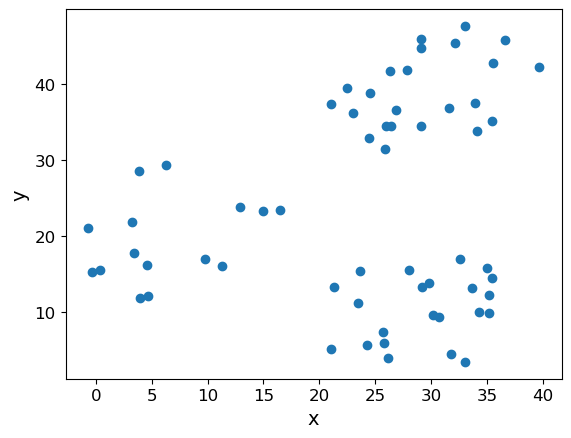

In [8]:
# Let's plot the data
# customcmap = ListedColormap(["crimson", "mediumblue", "darkmagenta"])


plt.scatter(
    x=blobs["x"],
    y=blobs["y"],
    # s=150,
    # c=blobs["cluster"].astype("category"),
    # cmap=customcmap,
)
plt.xlabel("x", fontsize=14)
plt.ylabel("y", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

### Kmeans algorithm
#### Step 1 and 2: Initialize centroids and assign clusters

In [10]:
def initiate_centroids(k, dset):
    """
    Select k data points as centroids
    k: number of centroids
    dset: pandas dataframe
    """
    centroids = dset.sample(k)
    return centroids


np.random.seed(42)
k = 3
df = blobs[["x", "y"]]
centroids = initiate_centroids(k, df)
centroids

,x,y
0,24.412,32.932
5,25.893,31.515
36,26.878,36.609


#### Step 3: Calculate distance
* we use Euclidean distance

In [11]:
def rsserr(a, b):
    """
    Calculate the root of sum of squared errors.
    a and b are numpy arrays
    """
    return np.square(np.sum((a - b) ** 2))

In [14]:
for i, centroid in enumerate(range(centroids.shape[0])):
    error = rsserr(centroids.iloc[centroid, :], df.iloc[10, :])
    # calculate the error from 3rd centroid to all centroids
    print(f"Error for centoroid {i} is {error:.2f}")

Error for centoroid 0 is 8361.62
Error for centoroid 1 is 12292.91
Error for centoroid 2 is 814.08


#### Step 4: Assign data points to new clusters(centroids)
* We assign data points to new clusters based on the distance from the centroids
* Nearest centroid is assigned to the data point

In [15]:
def centroid_assignation(dset, centroids):
    """
    Given a dataframe `dset` and a set of `centroids`, we assign each
    data point in `dset` to a centroid.
    - dset - pandas dataframe with observations
    - centroids - pa das dataframe with centroids
    """
    k = centroids.shape[0]
    n = dset.shape[0]
    assignation = []
    assign_errors = []

    for obs in range(n):
        # Estimate error
        all_errors = np.array([])
        for centroid in range(k):
            err = rsserr(centroids.iloc[centroid, :], dset.iloc[obs, :])
            all_errors = np.append(all_errors, err)

        # Get the nearest centroid and the error
        nearest_centroid = np.where(all_errors == np.amin(all_errors))[0].tolist()[0]
        nearest_centroid_error = np.amin(all_errors)

        # Add values to corresponding lists
        assignation.append(nearest_centroid)
        assign_errors.append(nearest_centroid_error)

    return assignation, assign_errors

In [16]:
# compute error and assign cetnroid, append the result to dataframe
df["centroid"], df["error"] = centroid_assignation(df, centroids)
df.head()

/tmp/ipykernel_135481/3782762560.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["centroid"], df["error"] = centroid_assignation(df, centroids)


,x,y,centroid,error
0,24.412,32.932,0,0.000000
1,35.190,12.189,1,211534.211314
2,26.288,41.718,2,699.601495
3,0.376,15.506,0,776856.744109
4,26.116,3.963,1,576327.599678


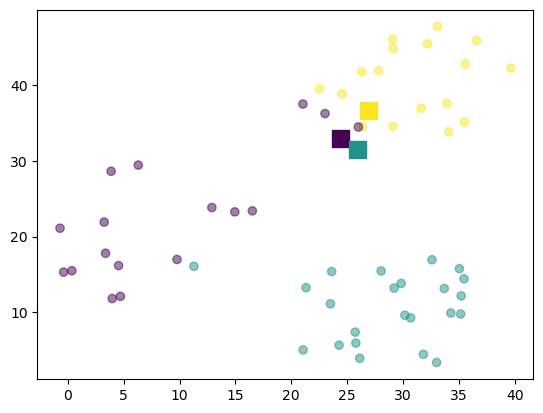

In [17]:
# plot the data
plt.scatter(df["x"], df["y"], c=df["centroid"], alpha=0.5)
plt.scatter(
    centroids["x"],
    centroids["y"],
    marker="s",
    s=150,
    c=[0, 1, 2],
)

In [18]:
print(f"The total error is {df['error'].sum():.2f}")

The total error is 11927659.01


#### Step 5: update centroids location
* We update the centroids location based on the mean of the data points assigned to the cluster

In [20]:
df.groupby("centroid").agg("mean")

,x,y,error
centroid,,,
0,9.889444,23.242611,305680.658786
1,28.435750,11.546250,261544.254472
2,30.759333,40.311167,8241.391249


In [21]:
# since we need xy coordinates, not error
centroids = df.groupby("centroid").agg("mean").reset_index()[["x", "y"]]
centroids

,x,y
0,9.889444,23.242611
1,28.435750,11.546250
2,30.759333,40.311167


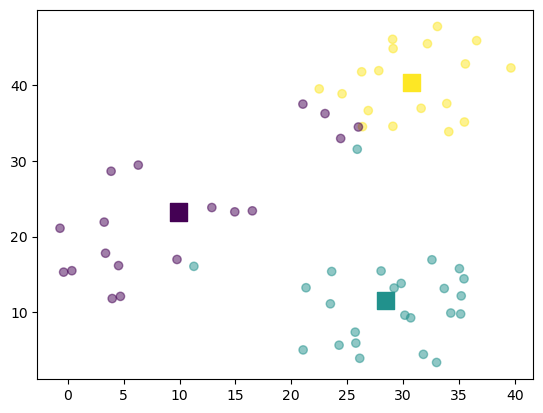

In [22]:
# verify update centroid position
plt.scatter(df["x"], df["y"], c=df["centroid"], alpha=0.5)
plt.scatter(
    centroids["x"],
    centroids["y"],
    marker="s",
    s=150,
    c=[0, 1, 2],
)

#### Step 6: Repeat step 3 to 5 until convergence

In [24]:
def kmeans(dset, k=2, tol=1e-4):
    """
    K-means implementationd for a
    `dset`:  DataFrame with observations
    `k`: number of clusters, default k=2
    `tol`: tolerance=1E-4
    """
    # Let us work in a copy, so we don't mess the original
    working_dset = dset.copy()
    # We define some variables to hold the error, the
    # stopping signal and a counter for the iterations
    err = []
    goahead = True
    j = 0

    # Step 2: Initiate clusters by defining centroids
    centroids = initiate_centroids(k, dset)

    while goahead:
        # Step 3 and 4 - Assign centroids and calculate error
        working_dset["centroid"], j_err = centroid_assignation(working_dset, centroids)
        err.append(sum(j_err))

        # Step 5 - Update centroid position
        centroids = working_dset.groupby("centroid").agg("mean").reset_index(drop=True)

        # Step 6 - Restart the iteration
        if j > 0:
            # Is the error less than a tolerance (1E-4)
            if err[j - 1] - err[j] <= tol:
                goahead = False
        j += 1

    working_dset["centroid"], j_err = centroid_assignation(working_dset, centroids)
    centroids = working_dset.groupby("centroid").agg("mean").reset_index(drop=True)
    return working_dset["centroid"], j_err, centroids

In [25]:
np.random.seed(42)
df["centroid"], df["error"], centroids = kmeans(df[["x", "y"]], 3)
df.head()

,x,y,centroid,error
0,24.412,32.932,2,3767.568743
1,35.190,12.189,1,1399.889001
2,26.288,41.718,2,262.961097
3,0.376,15.506,0,2683.086425
4,26.116,3.963,1,2723.650198


In [26]:
centroids

,x,y
0,6.322867,19.559800
1,29.330864,10.432409
2,29.304957,39.050783


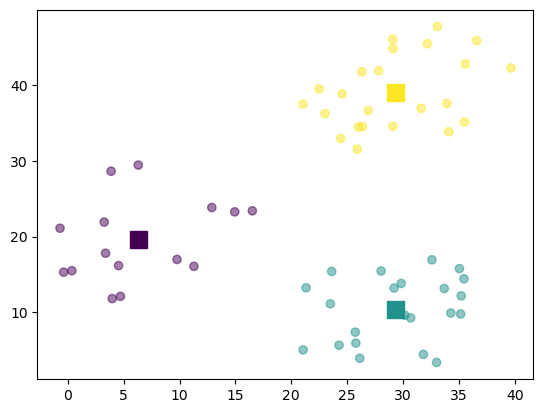

In [27]:
plt.scatter(df["x"], df["y"], c=df["centroid"], alpha=0.5)
plt.scatter(
    centroids["x"],
    centroids["y"],
    marker="s",
    s=150,
    c=[0, 1, 2],
)

#### Visualize the error convergence according to the number of clusters


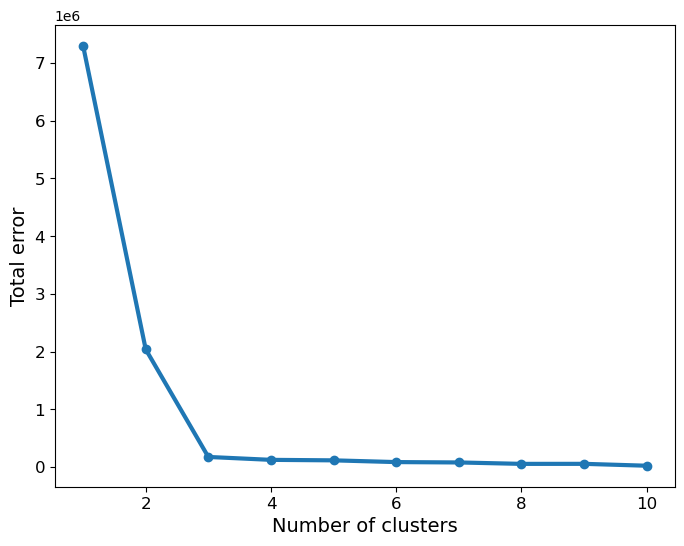

In [28]:
err_total = []
n = 10

df_elbow = blobs[["x", "y"]]

for i in range(n):
    _, my_errs, _ = kmeans(df_elbow, i + 1)
    err_total.append(sum(my_errs))
fig, ax = plt.subplots(figsize=(8, 6))
plt.plot(range(1, n + 1), err_total, linewidth=3, marker="o")
ax.set_xlabel(r"Number of clusters", fontsize=14)
ax.set_ylabel(r"Total error", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

### Sklearn Kmeans
* We can do this using sklearn Kmeans

In [29]:
# load libraries
from sklearn.cluster import KMeans

In [46]:
sklearn_kmeans = KMeans(n_clusters=4, random_state=50)

In [47]:
blobs_kmeans = sklearn_kmeans.fit(df[["x", "y"]])

/home/hyunsu4gpu/miniconda3/envs/EDA-tutorial/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [48]:
blobs_kmeans.labels_

array([2, 1, 2, 3, 1, 2, 1, 1, 2, 2, 0, 0, 0, 1, 3, 3, 1, 1, 3, 0, 3, 1,
       3, 2, 3, 1, 3, 2, 3, 0, 1, 1, 1, 2, 3, 1, 2, 0, 0, 3, 1, 0, 3, 3,
       1, 0, 1, 1, 0, 1, 3, 1, 3, 0, 2, 1, 2, 0, 1, 1], dtype=int32)

In [49]:
blobs_kmeans.cluster_centers_

array([[33.16925   , 41.66325   ],
       [29.33086364, 10.43240909],
       [25.08936364, 36.20081818],
       [ 6.32286667, 19.5598    ]])

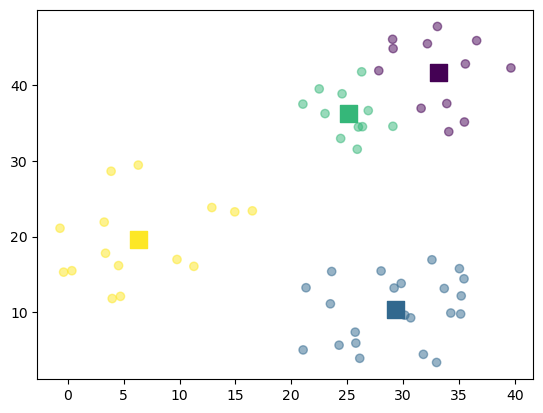

In [50]:
plt.scatter(df["x"], df["y"], c=blobs_kmeans.labels_, alpha=0.5)
plt.scatter(
    blobs_kmeans.cluster_centers_[:, 0],
    blobs_kmeans.cluster_centers_[:, 1],
    marker="s",
    s=150,
    c=[0, 1, 2, 3],
)